# Packages

In [1]:
import math

from ortools.constraint_solver import pywrapcp, routing_enums_pb2

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Route Optimization\\OR-Tools'

# Overview

One of the most common optimization tasks is *vehicle routing*, in which the goal is to find the **best routes for a fleet of vehicles visiting a set of locations**. Usually, "best" means routes with the least total distance or cost. Here are a few examples of routing problems:
- A package delivery company wants to assign routes for drivers to make deliveries.
- A cable TV company wants to assign routes for technicians to make residential service calls.
- A ride-sharing company wants to assign routes for drivers to pick up and drop off passengers.

The most famous routing problem is the *Traveling Salesperson Problem (TSP)*: find the shortest route for a salesperson who needs to visit customers at different locations and return to the starting point. A TSP can be represented by a graph, in which the nodes correspond to the locations, and the edges (or arcs) denote direct travel between locations. For example, the graph below shows a TSP with just four locations, labeled A, B, C, and D. The distance between any two locations is given by the number next to the edge joining them.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/tsp.svg'>
</p>

By calculating the distances of all possible routes, you can see that the shortest route is ACDBA, for which the total distance is 35 + 30 + 15 + 10 = 90.

The problem gets harder when there are more locations. In the example above, there are just six routes. But if there are ten locations (not counting the starting point), the number of routes is 362880. For 20 locations, the number jumps to 2432902008176640000. An exhaustive search of all possible routes would be guaranteed to find the shortest, but this is computationally intractable for all but small sets of locations. For larger problems, optimization techniques are needed to intelligently search the solution space and find an optimal (or near-optimal) solution.

A more general version of the TSP is the vehicle routing problem (VRP), in which there are multiple vehicles. In most cases, VRPs have constraints: for example, vehicles might have capacities for the maximum weight or volume of items they can carry, or drivers might be required to visit locations during specified time windows requested by customers. OR-Tools can solve many types of VRPs, including the following:
- **Traveling Salesperson Problem**, the classic routing problem in which there is just one vehicle
- **Vehicle routing problem**, a generalization of the TSP with multiple vehicles
- **VRP with capacity constraints**, in which vehicles have maximum capacities for the items they can carry
- **VRP with time windows**, where vehicles must visit the locations in specified time intervals before
- **VRP with resource constraints**, such as space or personnel to load and unload at the depot (starting point for the routes)
- **VRP with dropped visits**, where vehicles aren't required to visit all locations, but must pay a penalty for each visit dropped

Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take OR-Tools (or any other routing software) years to find the optimal solution. As a result, OR-Tools sometimes returns solutions that are good, but not optimal. To find a better solution, change the search options for the solver.

Note: We should add that there are other solvers, such as [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html), dedicated to solving very large TSPs to optimality, which surpass OR-Tools in that area. However, OR-Tools provides a better platform for solving more general routing problems that contain constraints beyond those of a pure TSP.

# Traveling Salesperson Problem

## US Problem

This section presents an example that shows how to solve the Traveling Salesperson Problem (TSP) for the locations shown on the map below.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/tsp_map.png'>
</p>

### Creating data

In [2]:
# Create data
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ]  # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

The distance matrix is an array whose i, j entry is the distance from location i to location j in miles, where the array indices correspond to the locations in the following order:

0. New York - 1. Los Angeles - 2. Chicago - 3. Minneapolis - 4. Denver - 5. Dallas - 6. Seattle - 7. Boston - 8. San Francisco - 9. St. Louis - 10. Houston - 11. Phoenix - 12. Salt Lake City

Note: The order of the locations in the distance matrix is arbitrary, and is unrelated to the order of locations in any solution to the TSP.

The data also includes:
- The number of vehicles in the problem, which is 1 because this is a TSP. (For a vehicle routing problem (VRP), the number of vehicles can be greater than 1.)
- The depot: the start and end location for the route. In this case, the depot is 0, which corresponds to New York.

Since the routing solver does all computations with integers, the distance callback must return an integer distance for any two locations. If any of the entries of `data['distance_matrix']` are not integers, you need to round either the matrix entries, or the return values of the callback, to integers. 

In this example, the distance matrix is explicitly defined in the program. It's also possible to use a function to calculate distances between locations: for example, the Euclidean formula for the distance between points in the plane. However, it's still more efficient to pre-compute all the distances between locations and store them in a matrix, rather than compute them at run time.

Another alternative is to use the [Google Maps Distance Matrix API](https://developers.google.com/optimization/routing/vrp#distance_matrix_api) to dynamically create a distance (or travel time) matrix for a routing problem.

### Create routing model

The following code in the main section of the programs creates the *index manager* (`manager`) and the routing model (`routing`). The method `manager.IndexToNode` converts the solver's internal indices (which you can safely ignore) to the numbers for locations. Location numbers correspond to the indices for the distance matrix.

The inputs to `RoutingIndexManager` are:
- The number of rows of the distance matrix, which is the number of locations (including the depot).
- The number of vehicles in the problem.
- The node corresponding to the depot.

In other problems, you can specify different start and end locations for the routes. To do so, you pass in two vectors, the first containing the start locations and the second containing the end locations, instead of a single **depot**.

In [3]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), 
                                        data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Create the distance callback

To use the routing solver, you need to create a distance (or transit) callback: a function that **takes any pair of locations and returns the distance between them**. The easiest way to do this is using the distance matrix.

The following function creates the callback and registers it with the solver as `transit_callback_index`. The callback accepts two indices, `from_index` and `to_index`, and returns the corresponding entry of the distance matrix.

In [4]:
def distance_callback(from_index, to_index):
    '''Returns the distance between the two nodes.'''
    # Convert from routing variable Index to distance matrix NodeIndex
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
transit_callback_index

1

### Set the cost of travel

The *arc cost evaluator* tells the solver how to calculate the cost of travel between any two locations—in other words, the cost of the edge (or arc) joining them in the graph for the problem. The following code sets the arc cost evaluator.

In this example, the arc cost evaluator is the `transit_callback_index`, which is the solver's internal reference to the distance callback. This means that the cost of travel between any two locations is just the distance between them. However, in general the costs can involve other factors as well.

You can also define multiple arc cost evaluators that depend on which vehicle is traveling between locations, using the method `routing.SetArcCostEvaluatorOfVehicle()`. For example, if the vehicles have different speeds, you could define the cost of travel between locations to be the distance divided by the vehicle's speed—in other words, the travel time.

In [5]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
routing

<ortools.constraint_solver.pywrapcp.RoutingModel; proxy of <Swig Object of type 'operations_research::RoutingModel *' at 0x000001F8AC4635A0> >

### Set search parameters

The following code sets the default search parameters and a heuristic method for finding the first solution. The code sets the first solution strategy to `PATH_CHEAPEST_ARC`, which creates an initial route for the solver by repeatedly adding edges with the least weight that don't lead to a previously visited node (other than the depot). For other options, see [First solution strategy](https://developers.google.com/optimization/routing/routing_options#first_sol_options).

In [6]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

search_parameters

first_solution_strategy: PATH_CHEAPEST_ARC
savings_neighbors_ratio: 1
savings_max_memory_usage_bytes: 6000000000
savings_arc_coefficient: 1
cheapest_insertion_first_solution_neighbors_ratio: 1
cheapest_insertion_first_solution_min_neighbors: 1
cheapest_insertion_ls_operator_neighbors_ratio: 1
cheapest_insertion_ls_operator_min_neighbors: 1
local_cheapest_insertion_evaluate_pickup_delivery_costs_independently: true
local_search_operators {
  use_relocate: BOOL_TRUE
  use_relocate_pair: BOOL_TRUE
  use_light_relocate_pair: BOOL_TRUE
  use_relocate_neighbors: BOOL_FALSE
  use_relocate_subtrip: BOOL_TRUE
  use_exchange: BOOL_TRUE
  use_exchange_pair: BOOL_TRUE
  use_exchange_subtrip: BOOL_TRUE
  use_cross: BOOL_TRUE
  use_cross_exchange: BOOL_FALSE
  use_relocate_expensive_chain: BOOL_TRUE
  use_two_opt: BOOL_TRUE
  use_or_opt: BOOL_TRUE
  use_lin_kernighan: BOOL_TRUE
  use_tsp_opt: BOOL_FALSE
  use_make_active: BOOL_TRUE
  use_relocate_and_make_active: BOOL_FALSE
  use_make_inactive: BOOL

### Add solution printer

The function displays the optimal route and its distance, which is given by `ObjectiveValue()`.

In [7]:
def print_solution(manager, routing, solution):
    '''Prints solution on console.'''
    
    print(f'Objective: {solution.ObjectiveValue()} miles')
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0

    while not routing.IsEnd(index):
        plan_output += f' {manager.IndexToNode(index)} ->'
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    plan_output += f' {manager.IndexToNode(index)}\n'
    print(plan_output)
    plan_output += f'Route distance: {route_distance}\n'

In [8]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 7293 miles
Route for vehicle 0:
 0 -> 7 -> 2 -> 3 -> 4 -> 12 -> 6 -> 8 -> 1 -> 11 -> 10 -> 5 -> 9 -> 0



### Save routes to a list of arrays

As an alternative to printing the solution directly, you can save the route (or routes, for a VRP) to a list or array. This has the advantage of making the routes available in case you want to do something with them later. For example, you could run the program several times with different parameters and save the routes in the returned solutions to a file for comparison.

The following functions save the routes in the solution to any VRP (possibly with multiple vehicles) as a list (Python) or an array (C++).

In [9]:
def get_routes(solution, routing, manager):
    '''Get vehicle routes from a solution and store them in an array.'''
    # Get vehicle routes and store them in a 2D array whose i, j entry is the jth location
    # visited by vehicle i along its route
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

routes = get_routes(solution, routing, manager)

# Display routes
for i, route in enumerate(routes):
    print('Route', i, route)

Route 0 [0, 7, 2, 3, 4, 12, 6, 8, 1, 11, 10, 5, 9, 0]


## Drilling a circuit board

The next example involves drilling holes in a circuit board with an automated drill. The problem is to find the shortest route for the drill to take on the board in order to drill all of the required holes. The example is taken from TSPLIB, a library of TSP problems.

Here's scatter chart of the locations for the holes:

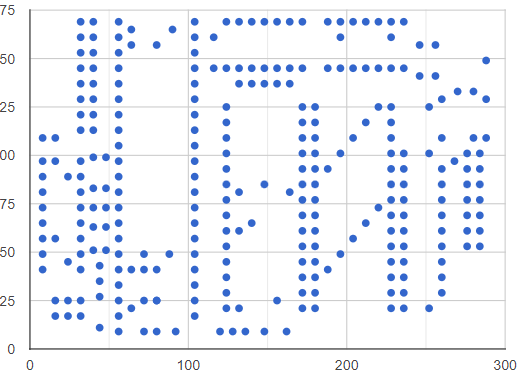



### Create data

In [10]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Locations in block units
    data['locations'] = [
        (288, 149), (288, 129), (270, 133), (256, 141), (256, 157), (246, 157),
        (236, 169), (228, 169), (228, 161), (220, 169), (212, 169), (204, 169),
        (196, 169), (188, 169), (196, 161), (188, 145), (172, 145), (164, 145),
        (156, 145), (148, 145), (140, 145), (148, 169), (164, 169), (172, 169),
        (156, 169), (140, 169), (132, 169), (124, 169), (116, 161), (104, 153),
        (104, 161), (104, 169), (90, 165), (80, 157), (64, 157), (64, 165),
        (56, 169), (56, 161), (56, 153), (56, 145), (56, 137), (56, 129),
        (56, 121), (40, 121), (40, 129), (40, 137), (40, 145), (40, 153),
        (40, 161), (40, 169), (32, 169), (32, 161), (32, 153), (32, 145),
        (32, 137), (32, 129), (32, 121), (32, 113), (40, 113), (56, 113),
        (56, 105), (48, 99), (40, 99), (32, 97), (32, 89), (24, 89),
        (16, 97), (16, 109), (8, 109), (8, 97), (8, 89), (8, 81),
        (8, 73), (8, 65), (8, 57), (16, 57), (8, 49), (8, 41),
        (24, 45), (32, 41), (32, 49), (32, 57), (32, 65), (32, 73),
        (32, 81), (40, 83), (40, 73), (40, 63), (40, 51), (44, 43),
        (44, 35), (44, 27), (32, 25), (24, 25), (16, 25), (16, 17),
        (24, 17), (32, 17), (44, 11), (56, 9), (56, 17), (56, 25),
        (56, 33), (56, 41), (64, 41), (72, 41), (72, 49), (56, 49),
        (48, 51), (56, 57), (56, 65), (48, 63), (48, 73), (56, 73),
        (56, 81), (48, 83), (56, 89), (56, 97), (104, 97), (104, 105),
        (104, 113), (104, 121), (104, 129), (104, 137), (104, 145), (116, 145),
        (124, 145), (132, 145), (132, 137), (140, 137), (148, 137), (156, 137),
        (164, 137), (172, 125), (172, 117), (172, 109), (172, 101), (172, 93),
        (172, 85), (180, 85), (180, 77), (180, 69), (180, 61), (180, 53),
        (172, 53), (172, 61), (172, 69), (172, 77), (164, 81), (148, 85),
        (124, 85), (124, 93), (124, 109), (124, 125), (124, 117), (124, 101),
        (104, 89), (104, 81), (104, 73), (104, 65), (104, 49), (104, 41),
        (104, 33), (104, 25), (104, 17), (92, 9), (80, 9), (72, 9),
        (64, 21), (72, 25), (80, 25), (80, 25), (80, 41), (88, 49),
        (104, 57), (124, 69), (124, 77), (132, 81), (140, 65), (132, 61),
        (124, 61), (124, 53), (124, 45), (124, 37), (124, 29), (132, 21),
        (124, 21), (120, 9), (128, 9), (136, 9), (148, 9), (162, 9),
        (156, 25), (172, 21), (180, 21), (180, 29), (172, 29), (172, 37),
        (172, 45), (180, 45), (180, 37), (188, 41), (196, 49), (204, 57),
        (212, 65), (220, 73), (228, 69), (228, 77), (236, 77), (236, 69),
        (236, 61), (228, 61), (228, 53), (236, 53), (236, 45), (228, 45),
        (228, 37), (236, 37), (236, 29), (228, 29), (228, 21), (236, 21),
        (252, 21), (260, 29), (260, 37), (260, 45), (260, 53), (260, 61),
        (260, 69), (260, 77), (276, 77), (276, 69), (276, 61), (276, 53),
        (284, 53), (284, 61), (284, 69), (284, 77), (284, 85), (284, 93),
        (284, 101), (288, 109), (280, 109), (276, 101), (276, 93), (276, 85),
        (268, 97), (260, 109), (252, 101), (260, 93), (260, 85), (236, 85),
        (228, 85), (228, 93), (236, 93), (236, 101), (228, 101), (228, 109),
        (228, 117), (228, 125), (220, 125), (212, 117), (204, 109), (196, 101),
        (188, 93), (180, 93), (180, 101), (180, 109), (180, 117), (180, 125),
        (196, 145), (204, 145), (212, 145), (220, 145), (228, 145), (236, 145),
        (246, 141), (252, 125), (260, 129), (280, 133)
    ]  # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

data = create_data_model()

### Compute the distance matrix

The function below computes the **Euclidean distance between any two points in the data** and stores it in an array. Because the routing solver works over the integers, the function rounds the computed distances to integers. Rounding doesn't affect the solution in this example, but might in other cases

In [11]:
def compute_euclidean_distance_matrix(locations):
    '''Creates callback to return distance between points'''

    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_node == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                                (from_node[1] - to_node[1]))
                ))
    return distances

### Add the distance callback

In [12]:
distance_matrix = compute_euclidean_distance_matrix(data['locations'])

def distance_callback(from_index, to_index):
    '''Returns the distance between two nodes'''

    # Convert from routing variable Index to distance matrix NodeIndex
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Solution printer

In [13]:
def print_solution(manager, routing, solution):
    '''Prints solution on console.'''

    print(f'Objective {solution.ObjectiveValue()}')
    index = routing.Start(0)
    plan_output = 'Route:\n'
    route_distance = 0

    while not routing.IsEnd(index):
        plan_output += f' {manager.IndexToNode(index)} ->'
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    plan_output += f' {manager.IndexToNode(index)}\n'
    print(plan_output)
    plan_output += f'Objective: {route_distance}m\n'

### Program

In [14]:
# Create routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['locations']),
                                    data['num_vehicles'], data['depot'])

# Create routing model
routing = pywrapcp.RoutingModel(manager)

distance_matrix = compute_euclidean_distance_matrix(data['locations'])

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve problem
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console
if solution:
    print_solution(manager, routing, solution)

Objective 2790
Route:
 0 -> 1 -> 279 -> 2 -> 278 -> 277 -> 248 -> 247 -> 243 -> 242 -> 241 -> 240 -> 239 -> 238 -> 245 -> 244 -> 246 -> 249 -> 250 -> 229 -> 228 -> 231 -> 230 -> 237 -> 236 -> 235 -> 234 -> 233 -> 232 -> 227 -> 226 -> 225 -> 224 -> 223 -> 222 -> 218 -> 221 -> 220 -> 219 -> 202 -> 203 -> 204 -> 205 -> 207 -> 206 -> 211 -> 212 -> 215 -> 216 -> 217 -> 214 -> 213 -> 210 -> 209 -> 208 -> 251 -> 254 -> 255 -> 257 -> 256 -> 253 -> 252 -> 139 -> 140 -> 141 -> 142 -> 143 -> 199 -> 201 -> 200 -> 195 -> 194 -> 193 -> 191 -> 190 -> 189 -> 188 -> 187 -> 163 -> 164 -> 165 -> 166 -> 167 -> 168 -> 169 -> 171 -> 170 -> 172 -> 105 -> 106 -> 104 -> 103 -> 107 -> 109 -> 110 -> 113 -> 114 -> 116 -> 117 -> 61 -> 62 -> 63 -> 65 -> 64 -> 84 -> 85 -> 115 -> 112 -> 86 -> 83 -> 82 -> 87 -> 111 -> 108 -> 89 -> 90 -> 91 -> 102 -> 101 -> 100 -> 99 -> 98 -> 97 -> 96 -> 95 -> 94 -> 93 -> 92 -> 79 -> 88 -> 81 -> 80 -> 78 -> 77 -> 76 -> 74 -> 75 -> 73 -> 72 -> 71 -> 70 -> 69 -> 66 -> 68 -> 67 -> 57 -> 5

## Changing the search strategy

The routing solver does not always return the optimal solution to a TSP, because routing problems are computationally intractable. For instance, the solution returned in the previous example is not the optimal route. To find a better solution, you can use a more advanced search strategy, called *guided local search*, which enables the solver to escape a *local minimum* — a solution that is shorter than all nearby routes, but which is not the global minimum. After moving away from the local minimum, the solver continues the search.

For other local search strategies, see [Local search options](https://developers.google.com/optimization/routing/routing_options#local_search_options).

```python
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaHeuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.seconds = 30
    search_parameters.log_search = True
```

The best algorithms can now routinely solve TSP instances with tens of thousands of nodes. (The record at the time of writing is the pla85900 instance in TSPLIB, a VLSI application with 85,900 nodes. For certain instances with millions of nodes, solutions have been found guaranteed to be within 1% of an optimal tour.)

### Scaling the distance matrix

Since the routing solver works over the integers, if your distance matrix has non-integer entries, you have to round the distances to integers. If some distances are small, rounding can affect the solution.

To avoid any issue with rounding, you can scale the distance matrix: **multiply all entries of the matrix by a large number** — say 100. This multiplies the length of any route by a factor of 100, but it doesn't change the solution. The advantage is that now when you round the matrix entries, the rounding amount (which is at most 0.5), is very small compared to the distances, so it won't affect the solution significantly.

If you scale the distance matrix, you also need to change the solution printer to divide the scaled route lengths by the scaling factor, so that it displays the unscaled distances of the routes.

# Vehicle Routing Problem

In the Vehicle Routing Problem (VRP), the goal is to find optimal routes for multiple vehicles visiting a set of locations. (When there's only one vehicle, it reduces to the Traveling Salesperson Problem.)

But what do we mean by "optimal routes" for a VRP? One answer is the routes with the least total distance. However, if there are no other constraints, the optimal solution is to assign just one vehicle to visit all locations, and find the shortest route for that vehicle. This is essentially the same problem as the TSP.

A better way to define optimal routes is to minimize the length of the longest single route among all vehicles. This is the right definition if the goal is to complete all deliveries as soon as possible. The VRP example below finds optimal routes defined this way.

Imagine a company that needs to visit its customers in a city made up of identical rectangular blocks. A diagram of the city is shown below, with the company location marked in black and the locations to visit in blue.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrp.svg'>
</p>

## Solving with OR-Tools

In [15]:
# Create data
def create_data_model():
    
    # distance_matrix: array of distances between locations on meters
    # num_locations: number of locations
    # num_vehicles: number of vehicles in the fleet
    # depot: index of the depot, the location where all vehicles start and end their routes

    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data

data = create_data_model()
data

{'distance_matrix': [[0,
   548,
   776,
   696,
   582,
   274,
   502,
   194,
   308,
   194,
   536,
   502,
   388,
   354,
   468,
   776,
   662],
  [548,
   0,
   684,
   308,
   194,
   502,
   730,
   354,
   696,
   742,
   1084,
   594,
   480,
   674,
   1016,
   868,
   1210],
  [776,
   684,
   0,
   992,
   878,
   502,
   274,
   810,
   468,
   742,
   400,
   1278,
   1164,
   1130,
   788,
   1552,
   754],
  [696,
   308,
   992,
   0,
   114,
   650,
   878,
   502,
   844,
   890,
   1232,
   514,
   628,
   822,
   1164,
   560,
   1358],
  [582,
   194,
   878,
   114,
   0,
   536,
   764,
   388,
   730,
   776,
   1118,
   400,
   514,
   708,
   1050,
   674,
   1244],
  [274,
   502,
   502,
   650,
   536,
   0,
   228,
   308,
   194,
   240,
   582,
   776,
   662,
   628,
   514,
   1050,
   708],
  [502,
   730,
   274,
   878,
   764,
   228,
   0,
   536,
   194,
   468,
   354,
   1004,
   890,
   856,
   514,
   1278,
   480],
  [194,
   354,
   8

To set up the example and compute the distance matrix, we have assigned the following x-y coordinates to the locations shown in the city diagram:

```text
    [(456, 320), # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640)]  # location 16
```

Note that the location coordinates are not included in the problem data: all you need to solve the problem is the distance matrix, which we have pre-computed. You only need the location data to identify the locations in the solution, which are denoted by their indices (0, 1, 2 ...) in the above list.

The main purpose of showing the location coordinates and the city diagram in this and other examples is to provide a visual display of the problem and its solution. But this is not essential for solving a VRP.

For convenience in setting up the problem, the distances between locations are calculated using Manhattan distance, in which the distance between two points, (x1, y1) and (x2, y2) is defined to be |x1 - x2| + |y1 - y2|. However, there is no special reason to use this definition. You can use whatever method is best suited to your problem to calculate distances. Or, you can obtain a distance matrix for any set of locations in the world using the Google Distance Matrix API.

The following function creates the distance callback, which returns the distances between locations, and passes it to the solver. It also sets the arc costs, which define the cost of travel, to be the distances of the arcs.

In [16]:
def distance_callback(from_index, to_index):
    '''Returns the distance between two nodes'''

    # Convert from routing variable Index to distannce matrix NodeIndex
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

To solve this VRP, you need to create a distance *dimension*, which **computes the cumulative distance traveled by each vehicle along its route**. You can then set a cost proportional to the maximum of the total distances along each route. Routing programs use dimensions to keep track of quantities that accumulate over a vehicle's route.

The following code creates the distance dimension, using the solver's `AddDimension` method. The argument `transit_callback_index` is the index for the distance_callback.

In [17]:
# Add a distance dimension
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,          # no slack
    3000,       # vehicle maximum travel distance
    True,       # Start cumulative to zero
    dimension_name
)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

The method `SetGlobalSpanCostCoefficient` sets a large coefficient (`100`) for the global span of the routes, which in this example is the maximum of the distances of the routes. This makes the global span the predominant factor in the objective function, so the program minimizes the length of the longest route.

In [18]:
# Solution printer
def print_solution(data, manager, routing, solution):
    '''Prints solution on console'''

    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle: {vehicle_id}\n'
        route_distance = 0

        while not routing.IsEnd(index):
            plan_output += f' {manager.IndexToNode(index)} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        
        plan_output += f'{manager.IndexToNode(index)}\n'
        plan_output += f'Distance of the route: {route_distance}m\n'
        print(plan_output)

        max_route_distance = max(route_distance, max_route_distance)
    print(f'Maximum of the route distances: {max_route_distance}m')

Let's run everything again.

In [19]:
# Create data
data = create_data_model()

# Create routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['depot'])

# Create routing model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add a distance dimension
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,          # no slack
    3000,       # vehicle maximum travel distance
    True,       # Start cumulative to zero
    dimension_name
)

distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Set first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve problem
solution = routing.SolveWithParameters(search_parameters)

# Print solution
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found')

Objective: 177500
Route for vehicle: 0
 0 -> 9 -> 10 -> 2 -> 6 -> 5 ->0
Distance of the route: 1712m

Route for vehicle: 1
 0 -> 16 -> 14 -> 8 ->0
Distance of the route: 1484m

Route for vehicle: 2
 0 -> 7 -> 1 -> 4 -> 3 ->0
Distance of the route: 1552m

Route for vehicle: 3
 0 -> 13 -> 15 -> 11 -> 12 ->0
Distance of the route: 1552m

Maximum of the route distances: 1712m


The locations in the routes are denoted by their indices in the locations list. All routes begin and end at the depot (`0`).

The diagram below shows the assigned routes, in which the location indices have been converted to the corresponding x-y coordinates.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrpgs_solution.svg'>
</p>

# Capacity Constraints

The capacitated vehicle routing problem (CVRP) is a VRP in which vehicles with limited carrying capacity need to pick up or deliver items at various locations. The items have a quantity, such as weight or volume, and the vehicles have a maximum capacity that they can carry. The problem is to pick up or deliver the items for the least cost, while never exceeding the capacity of the vehicles.

Note: In the following example, we assume that all items are being picked up. The program that solves this problem also works if all items are being delivered: in this case, you can think of the capacity constraint being applied when the vehicles leave the depot fully loaded. But the capacity constraints are implemented the same way in both cases.

## CVRP Example

Next, we describe an example of a VRP with capacity constraints. The example extends the previous VRP example and adds the following requirements. At each location there is a demand corresponding to the quantity of the item to be picked up. Also, each vehicle has a maximum capacity of 15. (We aren't specifying units for the demands or capacity.)

The grid below shows the locations to visit in blue and the company location in black. The demands are shown at the lower right of each location. See Location coordinates in the VRP section for more details about how the locations are defined.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/cvrp.svg'>
</p>

The problem is to find an assignment of routes to vehicles that has the shortest total distance, and such that the total amount a vehicle is carrying never exceeds its capacity.

## Solution with OR-Tools

In [20]:
# Create the data
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data

data = create_data_model()
data

{'distance_matrix': [[0,
   548,
   776,
   696,
   582,
   274,
   502,
   194,
   308,
   194,
   536,
   502,
   388,
   354,
   468,
   776,
   662],
  [548,
   0,
   684,
   308,
   194,
   502,
   730,
   354,
   696,
   742,
   1084,
   594,
   480,
   674,
   1016,
   868,
   1210],
  [776,
   684,
   0,
   992,
   878,
   502,
   274,
   810,
   468,
   742,
   400,
   1278,
   1164,
   1130,
   788,
   1552,
   754],
  [696,
   308,
   992,
   0,
   114,
   650,
   878,
   502,
   844,
   890,
   1232,
   514,
   628,
   822,
   1164,
   560,
   1358],
  [582,
   194,
   878,
   114,
   0,
   536,
   764,
   388,
   730,
   776,
   1118,
   400,
   514,
   708,
   1050,
   674,
   1244],
  [274,
   502,
   502,
   650,
   536,
   0,
   228,
   308,
   194,
   240,
   582,
   776,
   662,
   628,
   514,
   1050,
   708],
  [502,
   730,
   274,
   878,
   764,
   228,
   0,
   536,
   194,
   468,
   354,
   1004,
   890,
   856,
   514,
   1278,
   480],
  [194,
   354,
   8

The new items in the `data` are:
- **Demands**: Each location has a demand corresponding to the quantity -- for example, weight or volume -- of the item to be picked up
- **Capacities**: Each location has a capacity: the maximum quanity that the vehicle can hold. As a vehicle travels along its route, the total quantity of the items it is carrying can never exceed its capacity.

In addition to the distance callback, the solver also requires a **demand callback**, which returns the demand at each location, and a dimension for the capacity constraints.

In [21]:
def demand_callback(from_index):
    '''Returns the dmemand of the node.'''

    # Convert from routing variable Index to demands NodeIndex
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'], # vehicle maximum capacities
    True,   # Start cumulative to zero
    'Capacity'
)

True

Unlike the distance callback, which takes a pair of locations as inputs, the demand callback only depends on the location (`from_node`) of the delivery.

Since the capacity constraints involve the weight of the load a vehicle is carrying— a quantity that accumulates over the route—we need to create a dimension for capacities, similar to the distance dimension in the previous VRP example. In this case, we use the `AddDimensionWithVehicleCapacity` method, which takes a vector of capacities.

Since all the vehicle capacities in this example are the same, you could use the AddDimension method, which takes a single upper bound for all vehicle quantities. But `AddDimensionWithVehicleCapacity` handles the more general case in which different vehicles have different capacities.

**Problems with multiple cargo types and capacities** -- In more complex CVRPs, each vehicle might carry several different types of cargo, with a maximum capacity for each type. For example, a fuel delivery truck might carry several types of fuel, using multiple tanks with differing capacities. To handle problems like these, just create a different capacity callback and dimension for each cargo type (making sure to assign them unique names).

Now let's make a solution printer. The solution printer displays the route of each vehicle, along with its *cumulative* load: the total amount the vehicle is carrying at stop on its routes.

In [22]:
def print_solution(data, manager, routing, solution):
    '''Prints solution on console'''

    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}\n'
        route_distance = 0
        route_load = 0

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += f'  {node_index} Load({route_load}%)'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"  {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f'Load of the route: {route_load}\n'
        
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f'Total distance of all routes: {total_distance}m')
    print(f'Total load of all routes: {total_load}')

Let's create the program.

In [23]:
# Create data
data = create_data_model()

# Create routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                        data['num_vehicles'], data['depot'])

# Create routing model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add capacity constraint
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,
    data['vehicle_capacities'],
    True,
    'Capacity'
)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(1)

# Solve problem
solution = routing.SolveWithParameters(search_parameters)

# Print solution
if solution:
    print_solution(data, manager, routing, solution)

Objective: 6208
Route for vehicle 0
  0 Load(0%)  4 Load(4%)  3 Load(6%)  1 Load(7%)  7 Load(15%)  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 1
  0 Load(0%)  14 Load(4%)  16 Load(12%)  10 Load(14%)  9 Load(15%)  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 2
  0 Load(0%)  12 Load(2%)  11 Load(3%)  15 Load(11%)  13 Load(15%)  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 3
  0 Load(0%)  8 Load(8%)  2 Load(9%)  6 Load(13%)  5 Load(15%)  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Total distance of all routes: 6208m
Total load of all routes: 60


For each location on a route, the output shows:
- The index of the location
- The total load carried by the vehicle when it departs the location

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/cvrp_solution.svg'>
</p>

## What happens if a problem has no solution?

 A routing problem with constraints, such as a CVRP, might not have a feasible solution— for example, if the total quantity of the items being transported exceeds the total capacity of the vehicles. If you try to solve such a problem, the solver might run an exhaustive search which takes so long that eventually you have to give up and interrupt the program.

Usually this won't be an issue. But here are a couple of ways to prevent your program from running a long time when a problem has no solution:
- Set a **time limit** in the program, which stops the search even if no solution has been found. However, keep in mind that if the problem has a solution that requires a lengthy search, the program might reach the time limit before finding the solution.
- Set **penalties for dropping visits to locations**. This allows the solver to return a "solution" that doesn't visit all locations in case the problem is infeasible. See Penalties and Dropping Visits.

In general, it can be hard to tell if a given problem has a solution. Even for a CVRP in which total demand doesn't exceed total capacity, determining whether all the items will fit in the vehicles is a version of the multiple knapsack problem.

# VR with Pickups and Deliveries

## VRP Example with pickups and deliveries.

The diagram below shows the pickup and delivery locations on a grid similar to the one in the previous VRP example. For each item, there is a directed edge from the pickup location to the delivery location.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrp_pickup_delivery.svg'>
</p>

## Solving example with OR-Tools

***Creating the data***
The data for the problem includes the distance matrix from the previous VRP example, along with a list of pairs of pickup and delivery locations, data['pickups_deliveries'], corresponding to the directed edges in the diagram above. The code below defines the pickup and delivery locations.

```python
    data['pickups_deliveries'] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        [15, 11],
        [13, 12],
        [16, 14],
    ]
```

For each pair, the first entry is index of the pickup location, and the second is the index of the delivery location.


***Define pickup and delivery requests***
The following code defines pickup and delivery requests, using pickup and delivery locations in `data['pickups_deliveries']`.

```python
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))
```

For each pair, the command
```python
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
```

creates a pickup and delivery request item.

The following line adds the requirement that each item must be picked up and delivered by the same vehicle.

```python
    routing.solver().Add(
        routing.VehicleVar(pickup_index) = routing.VehicleVar(delivery_index)
    )
```

Finally, we add the obvious requirement that each item must be picked up before it is delivered. We require that a vehicle's cumulative distance at an item's pickup location is at most its cumulative distance at the delivery location.

```python
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index)
    )
```

In [24]:
"""Simple Pickup Delivery Problem (PDP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['pickups_deliveries'] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        [15, 11],
        [13, 12],
        [16, 14],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for vehicle 2:
 0 ->  4 ->  3 -> 0
Distance of the route: 1392m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Total Distance of all routes: 6916m


The following program shows these routes:

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrp_pickup_delivery_solution.svg'>
</p>

# Vehicle Routing Problem with Time Constraints

Many vehicle routing problems involve scheduling visits to customers who are only available during specific time windows. These problems are known as *vehicle routing problems with time windows (VRPTWs)*.

## VRPTW example

On this page, we'll walk through an example that shows how to solve a VRPTW. Since the problem involves time windows, the data include a *time matrix*, which contains the travel times between locations.

The diagram below shows the locations to visit in blue and the depot in black. The time windows are shown above each location. See Location coordinates in the VRP section for more details about how the locations are defined.

The goal is to **minimize the total travel time of the vehicles**.

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrptw.svg'>
</p>

## Solving with OR-Tools

### Create data

In [25]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data['time_windows'] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data

data = create_data_model()

The data consists of:
- `data['time_matrix']`: An array of travel times between locations. Note that this differs from previous examples, which use a distance matrix. If all vehicles travel at the same speed, you will get the same solution if you use a distance matrix or a time matrix, since travel distances are a constant multiple of travel times.
- `data['time_windows']`: An array of time windows for the locations, which you can think of as requested times for a visit. Vehicles must visit a location within its time window.
- `data['num_vehicles']`: The number of vehicles in the fleet.
- `data['depot']`: The index of the depot.

### Time callback

The following function creates the time callback and passes it to the solver. It also sets the arc costs, which define the cost of travel, to be the travel times between locations.

In [26]:
def time_callback(from_index, to_index):
    '''Returns travel time between two nodes'''

    # Convert from routing variable Index to time matrix NodeIndex
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Add time constraints

In [27]:
time = 'Time'
routing.AddDimension(
    transit_callback_index,
    30,             # allowing waiting time
    30,             # maximum time per vehicle
    False,          # don't force-start cumulative to zero
    time
)
time_dimension = routing.GetDimensionOrDie(time)

# Add time window constraints for each location except depot
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == data['depot']:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

# Add time window constraints for each vehicle start node
depot_idx = data['depot']
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        data['time_windows'][depot_idx][0],
        data['time_windows'][depot_idx][1]
    )
for i in range(data['num_vehicles']):
    routing.AddVariableMaximizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
    routing.AddVariableMaximizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

The code creates a dimension for the travel time of the vehicles, similar to the dimensions for travel distance or demands in previous examples. Dimensions keep track of quantities that accumulate over a vehicle's route. In the code above, `time_dimension.CumulVar(index)` is the cumulative travel time when a vehicle arrives at the location with the given `index`.

The dimension is created using the `AddDimension` method, which has the following arguments:
- The index for the travel time callback: `transit_callback_index`
- An upper bound for slack (the wait times at the locations): `30`. While this was set to 0 in the CVRP example, the VRPTW has to allow positive wait time due to the time window constraints.
- An upper bound for the total time over each vehicle's route: `30`
- A boolean variable that specifies **whether the cumulative variable is set to zero at the start of each vehicle's route**.
- The name of the dimension.

Next, the lines

```python
    timeDimension.CumulVar(index).SetRange(
        data.TimeWindows[0, 0],
        data.TimeWindows[0, 1]
    )
```

require that a vehicle must visit a location during the location's time window.

### Solution windows

The solution window at a location is the time interval during which a vehicle must arrive, in order to stay on schedule.The solution window is contained in—and usually smaller than—the constraint time window at the location.

In the solution printer function above, the solution window is returned by

```python
    (assignment.Min(time_var), assignment.Max(time_var))
```

where 

```python
    time_var = time_dimension.CumulVar(index)
```

is the vehicle's cumulative travel time at the location.

If the minimum and maximum values of `time_var` are the same, the solution window is a single point in time, which means the vehicle must depart from the location as soon as it arrives. On the other hand, if the minimum is less than the maximum, the vehicle can wait before departing.

### Saving solution windows to a list or array

Create functions to save the minimum and maximum values of the cumulative data for any dimension (not just time). In the current example, these values are the lower and upper bounds of the solution window, and the dimension passed to the function is `time_dimension`.

### Complete program

In [28]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data['time_windows'] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data

# Create other functions
def print_solution(data, manager, routing, solution):
    '''Prints solution on console.'''

    print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = f'Route for vehicle {vehicle_id}\n'
        
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += f' {manager.IndexToNode(index)} Time({solution.Min(time_var)}, {solution.Max(time_var)}) ->'
            index = solution.Value(routing.NextVar(index))
        
        time_var = time_dimension.CumulVar(index)
        plan_output += f'{manager.IndexToNode(index)} Time({solution.Min(time_var)}, {solution.Max(time_var)})\n'
        plan_output += f'Time of the route: {solution.Min(time_var)}min\n'
        
        print(plan_output)
        total_time += solution.Min(time_var)
    print(f'Total time of all routes: {total_time}min\n')

def main():
    # Instantiate the data problem
    data = create_data_model()

    # Create routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']), data['num_vehicles'], data['depot'])

    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add time windows constraint
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30, # allow waiting time
        30, # maximum time per vehicle
        False, # Don't force start cumul to zero
        time
    )
    time_dimension = routing.GetDimensionOrDie(time)

    # Add time window constraints for each location except the depot
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add time window constraints for each vehicle start node
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data['time_windows'][depot_idx][0],
            data['time_windows'][depot_idx][1]
        )

    # Instantiate route start and end times to produced feasible times
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution
    if solution:
        print_solution(data, manager, routing, solution)

if __name__ == '__main__':
    main()

Objective: 71
Route for vehicle 0
 0 Time(0, 0) -> 9 Time(2, 3) -> 14 Time(7, 8) -> 16 Time(11, 11) ->0 Time(18, 18)
Time of the route: 18min

Route for vehicle 1
 0 Time(0, 0) -> 7 Time(2, 4) -> 1 Time(7, 11) -> 4 Time(10, 13) -> 3 Time(16, 16) ->0 Time(24, 24)
Time of the route: 24min

Route for vehicle 2
 0 Time(0, 0) -> 12 Time(4, 4) -> 13 Time(6, 6) -> 15 Time(11, 11) -> 11 Time(14, 14) ->0 Time(20, 20)
Time of the route: 20min

Route for vehicle 3
 0 Time(0, 0) -> 5 Time(3, 3) -> 8 Time(5, 5) -> 6 Time(7, 7) -> 2 Time(10, 10) -> 10 Time(14, 14) ->0 Time(20, 20)
Time of the route: 20min

Total time of all routes: 82min



For each location on a route, `Time(a, b)` is the solution window: the vehicle that visits the location must do so in that time interval to stay on schedule.

As an example, take a look at the following portion of the route for vehicle 0.

```text
    0 Time(0, 0) -> 9 Time(2, 3) -> 14 Time(7, 8)
```

At location 9, the solution window is `Time(2, 3)`, which means the vehicle must arrive there between times 2 and 3. Note that the solution window is contained in the constraint time window at that location, `(0, 3)`, given in the problem data. The solution window starts at time 2 because it takes 2 units of time (the 0, 9 entry of the time matrix) to get from the depot to location 9.

Why can the vehicle depart location 9 anytime between 2 and 3? The reason is that since the travel time from location 9 to location 14 is 3, if the vehicle leaves anytime before 3, it will arrive at location 14 before time 6, which is too early for its visit. So the vehicle has to wait somewhere, and if the driver wanted to, he or she could wait at location 9 until time 3 without delaying completion of the route.

You may have noticed that some solution windows (e.g. at locations 9 and 14) have different start and end times, but others (e.g. on routes 2 and 3) have the same start and end time. In the former case, the vehicles can wait until the end of the window before departing, while in the latter, they must depart as soon as they arrive.

### Saving solution windows to a list or array

The TSP section shows how to save the routes in a solution to a list or array. For a VRPTW, you can also save the solution windows. 

The functions save the minimum and maximum values of the cumulative data for any dimension (not just time). In the current example, these values are the lower and upper bounds of the solution window, and the dimension passed to the function is `time_dimension`.

The following functions print the solution from the routes and the cumulative data.

In [29]:
def get_routes(solution, routing, manager):
    '''Get vehicle routes from a solution and store them in an array.'''
    # Get vehicle routes and store them in a 2D array whose i, j entry is the jth location
    # visited by vehicle i along its route
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def get_cumul_data(solution, routing, dimension):
    '''Get cumulative data from a dimension and store it in an array'''

    # Returns an array cumul_data whose i, j entry contains the minimum and maximum of
    # CumulVar for the dimension at the jth node on route:
        # - cumul_data[i][j][0] is the minimum
        # - cumul_data[i][j][1] is the maximum
    
    cumul_data = []

    for route_nbr in range(routing.vehicles()):
        route_data = []
        index = routing.Start(route_nbr)
        dim_var = dimension.CumulVar(index)
        route_data.append([solution.Min(dim_var), solution.Max(dim_var)])

        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            dim_var = dimension.CumulVar(index)
            route_data.append([solution.Min(dim_var), solution.Max(dim_var)])

        cumul_data.append(route_data)
    
    return cumul_data

def print_solution(routes, cumul_data):
    '''Print the solution.'''

    total_time = 0
    route_str = ''
    for i, route in enumerate(routes):
        route_str += 'Route ' + str(i) + ':\n'
        start_time = cumul_data[i][0][0]
        end_time = cumul_data[i][0][1]
        route_str += '  ' + str(route[0]) + \
            ' Time(' + str(start_time) + ', ' + str(end_time) + ')'
        
        for j in range(1, len(route)):
            start_time = cumul_data[i][j][0]
            end_time = cumul_data[i][j][1]
            route_str += ' -> ' + str(route[j]) + \
                ' Time(' + str(start_time) + ', ' + str(end_time) + ')'
        
        route_str += f'\n Route time: {start_time}\n\n'
        total_time += cumul_data[i][len(route) - 1][0]
    route_str += f'Total time: {total_time}min'
    print(route_str)

Complete program.

In [30]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data['time_windows'] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (16, 18),  # 3
        (10, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 4),  # 7
        (5, 10),  # 8
        (0, 3),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 8),  # 14
        (10, 15),  # 15
        (11, 15),  # 16
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data

# Create other functions
def get_routes(solution, routing, manager):
    '''Get vehicle routes from a solution and store them in an array.'''
    # Get vehicle routes and store them in a 2D array whose i, j entry is the jth location
    # visited by vehicle i along its route
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

def get_cumul_data(solution, routing, dimension):
    '''Get cumulative data from a dimension and store it in an array'''

    # Returns an array cumul_data whose i, j entry contains the minimum and maximum of
    # CumulVar for the dimension at the jth node on route:
        # - cumul_data[i][j][0] is the minimum
        # - cumul_data[i][j][1] is the maximum
    
    cumul_data = []

    for route_nbr in range(routing.vehicles()):
        route_data = []
        index = routing.Start(route_nbr)
        dim_var = dimension.CumulVar(index)
        route_data.append([solution.Min(dim_var), solution.Max(dim_var)])

        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            dim_var = dimension.CumulVar(index)
            route_data.append([solution.Min(dim_var), solution.Max(dim_var)])

        cumul_data.append(route_data)
    
    return cumul_data

def print_solution(routes, cumul_data):
    '''Print the solution.'''

    total_time = 0
    route_str = ''
    for i, route in enumerate(routes):
        route_str += 'Route ' + str(i) + ':\n'
        start_time = cumul_data[i][0][0]
        end_time = cumul_data[i][0][1]
        route_str += '  ' + str(route[0]) + \
            ' Time(' + str(start_time) + ', ' + str(end_time) + ')'
        
        for j in range(1, len(route)):
            start_time = cumul_data[i][j][0]
            end_time = cumul_data[i][j][1]
            route_str += ' -> ' + str(route[j]) + \
                ' Time(' + str(start_time) + ', ' + str(end_time) + ')'
        
        route_str += f'\n Route time: {start_time}\n\n'
        total_time += cumul_data[i][len(route) - 1][0]
    route_str += f'Total time: {total_time}min'
    print(route_str)

def main():
    # Instantiate the data problem
    data = create_data_model()

    # Create routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']), data['num_vehicles'], data['depot'])

    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add time windows constraint
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30, # allow waiting time
        30, # maximum time per vehicle
        False, # Don't force start cumul to zero
        time
    )
    time_dimension = routing.GetDimensionOrDie(time)

    # Add time window constraints for each location except the depot
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Add time window constraints for each vehicle start node
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data['time_windows'][depot_idx][0],
            data['time_windows'][depot_idx][1]
        )

    # Instantiate route start and end times to produced feasible times
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(time_dimension.CumulVar(routing.End(i)))

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution
    if solution:
        routes = get_routes(solution, routing, manager)
        cumul_data = get_cumul_data(solution, routing, time_dimension)
        print_solution(routes, cumul_data)

if __name__ == '__main__':
    main()

Route 0:
  0 Time(0, 0) -> 9 Time(2, 3) -> 14 Time(7, 8) -> 16 Time(11, 11) -> 0 Time(18, 18)
 Route time: 18

Route 1:
  0 Time(0, 0) -> 7 Time(2, 4) -> 1 Time(7, 11) -> 4 Time(10, 13) -> 3 Time(16, 16) -> 0 Time(24, 24)
 Route time: 24

Route 2:
  0 Time(0, 0) -> 12 Time(4, 4) -> 13 Time(6, 6) -> 15 Time(11, 11) -> 11 Time(14, 14) -> 0 Time(20, 20)
 Route time: 20

Route 3:
  0 Time(0, 0) -> 5 Time(3, 3) -> 8 Time(5, 5) -> 6 Time(7, 7) -> 2 Time(10, 10) -> 10 Time(14, 14) -> 0 Time(20, 20)
 Route time: 20

Total time: 82min


# Dimensions

The routing solver uses an object called a *dimension* to keep track of quantities that accumulate along a vehicle's route, such as the travel time or, if the vehicle is making pickups and deliveries, the total weight it is carrying. If a routing problem involves such a quantity, either in the constraints or the objective function, you need to define a dimension to specify them.

## Examples of dimensions

Here are a couple of examples of dimensions from previous sections.
- The VRPTW example creates a dimension to track each vehicle's **cumulative travel time**. The solver uses the dimension to enforce the constraint that a vehicle can only visit a location within the location's time window.
- The CVRP example creates a dimension for the *demands* (e.g., weights or volumes of packages to be picked up), which tracks the cumulative load the vehicle is carrying along its route. The solver uses the dimension to enforce the constraint that a vehicle's load can't exceed its capacity.

The examples below define a dimension for the VRPTW using the `AddDimension` method.

```python
    routing.AddDimension(
        callback_index,
        slack_max,
        capacity,
        fx_start_cumul_to_zero,
        dimension_name
    )
```

The `AddDimension` method has the following inputs:
- `callback_index`: The index for the callback that returns the quantity. The index, which is the solver's internal reference to the callback, is created by methods such as `RegisterTransitCallback` or `RegisterUnitaryTransitCallback`.
- `slack_max`: Maximum for the slack, a variable used to represent waiting times at the locations. See slack variables below for details. If the problem doesn't involve waiting time, you can usually set `slack_max` to `0`.
- `capacity`: Maximum for the total quantity accumulated along each route. Use capacity to create constraints like those in the CVRP. If your problem doesn't have such a constraint, you can set capacity to a value that is sufficiently large to impose no restrictions on the routes—for example, the sum of all entries of the matrix or array used to define the callback.
- `fix_start_cumulative_to_zero`: Boolean value. If true, the cumulative value of the quantity starts at 0. In most cases, this should be set to True. However, for the VRPTW or problems with resource constraints, some vehicles may have to start after time 0 due to time window constraints, so you should set `fix_start_cumulative_to_zero` to `False` for these problems.
- `dimension_name`: String for the name for the dimension, such as `'Distance'`, which you can use to access the variables elsewhere in the program.

The CVRP program creates a slightly different type of dimension using the the `AddDimensionWithVehicleCapacity` method. This method takes an array of capacities, with one entry for each vehicle. (In contrast, `AddDimension` takes a single value for `capacity`, so all vehicles are assumed to have the same capacity.)

## Slack variables

Here's an example that illustrates slack variables for a problem involving travel time. Suppose that a vehicle goes from location i to location j in one step of its route, and that:
- The vehicle's cumulative travel time at i is 100 minutes.
- The vehicle's cumulative travel time at j is 200 minutes.
- The travel time from i to j is 75 minutes.

The vehicle can't leave location i immediately upon arrival, or its cumulative time at location j would be 175. Instead, vehicle must wait for 25 minutes at location i before departing; in other words, the slack at location i is 25.

You need to allow slack in a VRPTW because vehicles **may have to wait before visiting a location, due to time window constraints**. In a problem like this, set `slack_max` to the maximum amount of time you want to allow vehicles to wait at a location before proceeding to the next location. If it doesn't matter how long they wait, just set `slack_max` to a very large number.

For the CVRP, on the other hand, the change in the accumulated load from i to j always equals the demand at i, so there is no slack. For problems like this, you can set `slack_max` to 0.

Next, we'll give the formal definition of slack. Internally, a dimension stores two types of variables related to quantities that accumulate along routes:
- **Transit variables**: The increase or decrease of the quantity at each step of a route. If i -> j is one step in a route, the transit variable is either the the i, j entry of the transit matrix (for a transit callback), or simply the callback value at location i (if the callback depends on just one location).
- **Cumulative variables**: The total accumulated quantity at each location. You can access the cumulative variable at location i by dimension_name.CumulVar(i). For an example, see the time window constraints in the VRPTW example.

Assuming that a vehicle goes from location i to location j in one step, the slack is related to these variables as follows:
```python
    slack(i) = cumul(j) - cumul(i) - transit(i, j)
```

# Resource Constraints

Up to now, we have been looking at routing problems with constraints that apply during vehicle travel. Next, we present a VRPTW that also has constraints at the depot: **all vehicles need to be loaded before departing the depot and unloaded upon return**. Since there are only two available loading docks, at most two vehicles can be loaded or unloaded at the same time. As a result, **some vehicles must wait for others to be loaded**, delaying their departure from the depot. The problem is to find optimal vehicle routes for the VRPTW that also meet the loading and unloading constraints at the depot.

## VRPTW example with resource constraints

<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrp_resources.svg'>
</p>

## Solving with OR-Tools

In [31]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data['time_windows'] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (5, 14),  # 3
        (5, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 10),  # 7
        (5, 10),  # 8
        (0, 5),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 12),  # 14
        (10, 15),  # 15
        (5, 15),  # 16
    ]
    data['num_vehicles'] = 4
    data['vehicle_load_time'] = 5
    data['vehicle_unload_time'] = 5
    data['depot_capacity'] = 2
    data['depot'] = 0
    return data

data = create_data_model()

The data includes the following:
- `time_matrix`: An array of travel times between locations.
- `time_windows`: An array of time windows for requested visits to the locations.
- `vehicle_load_time`: The time required to load a vehicle.
- `vehicle_unload_time`: The time required to unload a vehicle.
- `depot_capacity`: The maximum number of vehicles that can load or unload at the same time.

### Add time windows for loading and unloading

The following code adds time windows for loading and unloading the vehicles at the depot. These windows, created by the method `FixedDurationIntervalVar`, are **variable time windows**, meaning they don't have fixed start and end times (unlike the time windows at the locations). The widths of the windows are specified by `vehicle_load_time` and `vehicle_unload_time`, which happen to be the same in this example.

In [32]:
solver = routing.solver()
intervals = []
for i in range(data['num_vehicles']):
    # Add time windows at start of routes
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.Start(i)),
            data['vehicle_load_time'], 'depot_interval'))
    # Add time windows at end of routes.
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.End(i)),
            data['vehicle_unload_time'], 'depot_interval'))

### Add resource constraints at the depot

In [33]:
depot_usage = [1 for i in range(len(intervals))]
solver.Add(
    solver.Cumulative(intervals, depot_usage, data['depot_capacity'],
                        'depot'))

The following code creates the contraint that at most two vehicles can be loaded or unloaded at the same time.
- `depot_capacity` is the maximum number of vehicles that can be loaded or unloaded at the same time, which is 2 in this example.
- `depot_usage` is a vector containing the relative amounts of space required by each vehicle during loading (or unloading). In this example, we assume that all vehicles require the same amount of space, so `depot_usage` contains all ones. This means that the maximum number of vehicles that can be loaded at the same time is 2.

Let's run the program.

In [34]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
    ]
    data['time_windows'] = [
        (0, 5),  # depot
        (7, 12),  # 1
        (10, 15),  # 2
        (5, 14),  # 3
        (5, 13),  # 4
        (0, 5),  # 5
        (5, 10),  # 6
        (0, 10),  # 7
        (5, 10),  # 8
        (0, 5),  # 9
        (10, 16),  # 10
        (10, 15),  # 11
        (0, 5),  # 12
        (5, 10),  # 13
        (7, 12),  # 14
        (10, 15),  # 15
        (5, 15),  # 16
    ]
    data['num_vehicles'] = 4
    data['vehicle_load_time'] = 5
    data['vehicle_unload_time'] = 5
    data['depot_capacity'] = 2
    data['depot'] = 0
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1}, {2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1}, {2})\n'.format(manager.IndexToNode(index),
                                                    solution.Min(time_var),
                                                    solution.Max(time_var))
        plan_output += 'Time of the route: {}min\n'.format(
            solution.Min(time_var))
        print(plan_output)
        total_time += solution.Min(time_var)
    print('Total time of all routes: {}min'.format(total_time))

def main():
    '''Solve the VRP with time windows.'''
    # Instantiate the data problem
    data = create_data_model()

    # Create routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                        data['num_vehicles'], data['depot'])

    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        60,  # allow waiting time
        60,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
    
    # Add resource constriants at the depot
    solver = routing.solver()
    intervals = []

    for i in range(data['num_vehicles']):
        # Add time windows at start of routes
        intervals.append(
            solver.FixedDurationIntervalVar(
                time_dimension.CumulVar(routing.Start(i)),
                data['vehicle_load_time'],
                'depot_interval'
            )
        )
        
        # Add time windows at end of routes
        intervals.append(
            solver.FixedDurationIntervalVar(
                time_dimension.CumulVar(routing.End(i)),
                data['vehicle_unload_time'],
                'depot_interval'
            )
        )
    
    depot_usage = [1 for i in range(len(intervals))]
    solver.Add(
        solver.Cumulative(intervals, depot_usage, data['depot_capacity'], 'depot')
    )

    # Instantiate route start and end times to produced feasible times
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i))
        )
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i))
        )

    # Set first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print('No solution found!')

if __name__ == '__main__':
    main()

Objective: 71
Route for vehicle 0:
0 Time(5, 5) -> 8 Time(8, 9) -> 14 Time(11, 12) -> 16 Time(13, 15) -> 0 Time(25, 25)
Time of the route: 25min

Route for vehicle 1:
0 Time(0, 0) -> 12 Time(4, 4) -> 13 Time(6, 6) -> 15 Time(11, 11) -> 11 Time(14, 14) -> 0 Time(20, 20)
Time of the route: 20min

Route for vehicle 2:
0 Time(5, 5) -> 7 Time(7, 7) -> 1 Time(11, 11) -> 4 Time(13, 13) -> 3 Time(14, 14) -> 0 Time(24, 24)
Time of the route: 24min

Route for vehicle 3:
0 Time(0, 0) -> 9 Time(2, 3) -> 5 Time(4, 5) -> 6 Time(6, 9) -> 2 Time(10, 12) -> 10 Time(14, 16) -> 0 Time(29, 29)
Time of the route: 29min

Total time of all routes: 98min


<p align = 'center'>
    <img src = 'https://developers.google.com/static/optimization/images/routing/vrp_resources_solution.svg'>
</p>

# Penalties and Dropping Visits

We explain how to handle routing problems that have no feasible solution, due to constraints. For example, if you are given a VRP with capacity constraints in which the total demand at all locations exceeds the total capacity of the vehicles, no solution is possible. In such cases, the vehicles must drop visits to some locations. The problem is how to decide which visits to drop.

To solve the problem, we introduce new costs — called *penalties* — at all locations. Whenever a visit to a location is dropped, the penalty is added to the total distance traveled. The solver then finds a route that minimizes the total distance plus the sum of the penalties for all dropped locations.

As an example, consider the simple VRP with capacity constraints given by the graph below, in which the numbers next to the three locations (other than the depot) are demands.

<p align = center>
    <img src = https://developers.google.com/static/optimization/images/routing/tsp_no_animation.svg>
</p>

Suppose there is just one vehicle with capacity 50. It can't visit all three locations, A, B, and C, because the total demand is 60. To solve the problem, you assign a large penalty—say 100—to each location. After detecting that the problem is infeasible, the solver drops location B and returns the following route:

```text
Depot -> A -> C -> Depot
```

This is the shortest route that visits two of the three locations (the distance is 55).

## Penalty sizes

In the example above, we chose penalties that are larger than the sum of all distances between locations (excluding the depot). As a result, after dropping one location to make the problem feasible, the solver doesn't drop any additional locations, because the penalty for doing so would exceed any further reduction in travel distance. Assuming you want to make as many deliveries as possible, this gives a satisfactory solution to the problem.

If you don't need to make as many deliveries as possible, you might want to assign smaller penalties, in which case the solver may drop more locations than is necessary to make the problem feasible. For example, you might do this if there are additional costs, above the basic travel cost, to visiting certain locations.

## Example

Next, we present a larger example of a VRP that can be solved using penalties. The example is similar to the previous CVRP example, but this time we have increased some of the demands, forcing some vehicles to drop visits. A graph of the locations and new demands is shown below.

<p align = center>
    <img src = https://developers.google.com/static/optimization/images/routing/vrp_drop_nodes.svg>
</p>

## Solve with OR-Tools

### Creating data

Includes data from previous VRP example, but adds following demands and capacities:
```python
    data['demands'] = [0, 1, 1, 3, 6, 3, 6, 8, 8, 1, 2, 1, 2, 6, 6, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
```

### Add capacity constraints and penalties

The following code adds the demand callback and capacity constraints, and adds penalties using the `AddDisjunction` method.

```python
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    # Allow to drop nodes.
    penalty = 1000
    for node in range(1, len(data['distance_matrix'])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)
```

In this context, a *disjunction* is simply a variable that the solver uses to decide whether to include a given location in the solution. In this example, the method adds the same penalty to each location, but in general you can add different penalties to different locations.

### Add solution printer

This is similar to ones in previous examples, but also displays the dropped locations.

```python
def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    print(f'Objective: {assignment.ObjectiveValue()}')
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    # Display routes
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total Distance of all routes: {}m'.format(total_distance))
    print('Total Load of all routes: {}'.format(total_load))
```

### Complete program

In [35]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['demands'] = [0, 1, 1, 3, 6, 3, 6, 8, 8, 1, 2, 1, 2, 6, 6, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    print(f'Objective: {assignment.ObjectiveValue()}')
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if assignment.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
    print(dropped_nodes)
    # Display routes
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total Distance of all routes: {}m'.format(total_distance))
    print('Total Load of all routes: {}'.format(total_load))


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    # Allow to drop nodes.
    penalty = 1000
    for node in range(1, len(data['distance_matrix'])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)


if __name__ == '__main__':
    main()

Objective: 7548
Dropped nodes: 15 16
Route for vehicle 0:
 0 Load(0) ->  8 Load(8) ->  14 Load(14) ->  9 Load(15) ->  0 Load(15)
Distance of the route: 1096m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  1 Load(1) ->  3 Load(4) ->  4 Load(10) ->  11 Load(11) ->  12 Load(13) ->  0 Load(13)
Distance of the route: 1872m
Load of the route: 13

Route for vehicle 2:
 0 Load(0) ->  7 Load(8) ->  13 Load(14) ->  0 Load(14)
Distance of the route: 868m
Load of the route: 14

Route for vehicle 3:
 0 Load(0) ->  5 Load(3) ->  6 Load(9) ->  2 Load(10) ->  10 Load(12) ->  0 Load(12)
Distance of the route: 1712m
Load of the route: 12

Total Distance of all routes: 5548m
Total Load of all routes: 54


Here's a diagram of the routes:

<p align = center>
    <img src = https://developers.google.com/static/optimization/images/routing/vrp_drop_nodes_solution.svg>
</p>

# Common Routing Tasks

## Search limits

Vehicle routing problems with many locations can take a long time to solve. For such problems, it is a good idea to set a search limit, which terminates the search after a specified length of time or number of solutions returned.

### Time limits

Setting a time limit of 30 seconds for a search:
```python
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 30
```

### Solution limits

Setting a solution limit of 100 for a search:
```python
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.solution_limit = 100
```

## Setting initial routes for a search

For some problems, you might want to specify a set of initial routes for a VRP, rather than letting the solver find an initial solution. For example, if you have already found a good solution to a problem, and want to use it as a starting point to solve a modified problem.

To create the initial routes do the following steps:
1. Define an array containing the initial routes.
2. Create the initial solution using the method ReadAssignmentFromRoutes.

The following code defines the initial routes in the data. Note: The initial routes do not include the depot.

```python
    data['initial_routes'] = [
        [8, 16, 14, 13, 12, 11],
        [3, 4, 9, 10],
        [15, 1],
        [7, 5, 2, 6],
    ]
```

The following code creates an initial solution from the routes and then performs a search starting at the initial solution. The program displays both the initial solution and the solution foudn by the search.

```python
    initial_solution = routing.ReadAssignmentFromRoutes(data['initial_routes'],
                                                        True)
    print('Initial solution:')
    print_solution(data, manager, routing, initial_solution)
```

When you add this to the previous VRP program, it displays this:

```text
Initial solution:

Route for vehicle 0:
 0 ->  8 ->  16 ->  14 ->  13 ->  12 ->  11 -> 0
Distance of the route: 2168m

Route for vehicle 1:
 0 ->  3 ->  4 ->  9 ->  10 -> 0
Distance of the route: 2464m

Route for vehicle 2:
 0 ->  15 ->  1 -> 0
Distance of the route: 2192m

Route for vehicle 3:
 0 ->  7 ->  5 ->  2 ->  6 -> 0
Distance of the route: 1780m

Maximum of the route distances: 2464m

Solution after search:

Route for vehicle 0:
 0 ->  9 ->  10 ->  16 ->  14 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  12 ->  11 ->  15 ->  13 -> 0
Distance of the route: 1552

Route for vehicle 2:
 0 ->  3 ->  4 ->  1 ->  7 -> 0
Distance of the route: 1552

Route for vehicle 3:
 0 ->  5 ->  2 ->  6 ->  8 -> 0
Distance of the route: 1552

Maximum of the route distances: 1552
```

In [36]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['initial_routes'] = [
        [8, 16, 14, 13, 12, 11],
        [3, 4, 9, 10],
        [15, 1],
        [7, 5, 2, 6],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

def main():
    # Instantiate data
    data = create_data_model()

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create routing model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def distance_callback(from_index, to_index):
        '''Returns distance between nodes'''
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,
        3000,
        True,
        dimension_name
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Close model with custom search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(5)
    # When an initial solution is given for search, the model will be closed with the default
    # search parameters unless it is explicity closed with custom search parameters
    routing.CloseModelWithParameters(search_parameters)

    # Get initial solution from routes afater closing model
    initial_solution = routing.ReadAssignmentFromRoutes(data['initial_routes'], True)
    print('Initial solution:')
    print_solution(data, manager, routing, initial_solution)

    # Solve problem
    solution = routing.SolveFromAssignmentWithParameters(initial_solution, search_parameters)

    # Print solution
    if solution:
        print('Solution after search:')
        print_solution(data, manager, routing, solution)

if __name__ == '__main__':
    main()

Initial solution:
Objective: 255004
Route for vehicle 0:
 0 ->  8 ->  16 ->  14 ->  13 ->  12 ->  11 -> 0
Distance of the route: 2168m

Route for vehicle 1:
 0 ->  3 ->  4 ->  9 ->  10 -> 0
Distance of the route: 2464m

Route for vehicle 2:
 0 ->  15 ->  1 -> 0
Distance of the route: 2192m

Route for vehicle 3:
 0 ->  7 ->  5 ->  2 ->  6 -> 0
Distance of the route: 1780m

Maximum of the route distances: 2464m
Solution after search:
Objective: 161408
Route for vehicle 0:
 0 ->  9 ->  10 ->  16 ->  14 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  12 ->  11 ->  15 ->  13 -> 0
Distance of the route: 1552m

Route for vehicle 2:
 0 ->  3 ->  4 ->  1 ->  7 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  5 ->  2 ->  6 ->  8 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1552m


## Setting start and end locations for routes

So far, we have assumed that all vehicles start and end at a single location, the depot. You can also set possibly different start and end locations for each vehicle in the problem. To do so, pass two vectors, containing the indices of the start and end locations, as inputs to the RoutingModel method in the main function. Here's how to create the start and end vectors in the data section of the program:

```python
    data['starts'] = [1, 2, 15, 16]
    data['ends'] = [0, 0, 0, 0]
```

In [1]:
"""Simple Vehicles Routing Problem."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 4
    data['starts'] = [1, 2, 15, 16]
    data['ends'] = [0, 0, 0, 0]
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)# 
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        2000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 115794
Route for vehicle 0:
 1 ->  4 ->  3 ->  7 -> 0
Distance of the route: 1004m

Route for vehicle 1:
 2 ->  6 ->  8 ->  5 -> 0
Distance of the route: 936m

Route for vehicle 2:
 15 ->  11 ->  12 ->  13 -> 0
Distance of the route: 936m

Route for vehicle 3:
 16 ->  14 ->  10 ->  9 -> 0
Distance of the route: 1118m

Maximum of the route distances: 1118m


In [2]:
data = create_data_model()
data['distance_matrix']

[[0,
  548,
  776,
  696,
  582,
  274,
  502,
  194,
  308,
  194,
  536,
  502,
  388,
  354,
  468,
  776,
  662],
 [548,
  0,
  684,
  308,
  194,
  502,
  730,
  354,
  696,
  742,
  1084,
  594,
  480,
  674,
  1016,
  868,
  1210],
 [776,
  684,
  0,
  992,
  878,
  502,
  274,
  810,
  468,
  742,
  400,
  1278,
  1164,
  1130,
  788,
  1552,
  754],
 [696,
  308,
  992,
  0,
  114,
  650,
  878,
  502,
  844,
  890,
  1232,
  514,
  628,
  822,
  1164,
  560,
  1358],
 [582,
  194,
  878,
  114,
  0,
  536,
  764,
  388,
  730,
  776,
  1118,
  400,
  514,
  708,
  1050,
  674,
  1244],
 [274,
  502,
  502,
  650,
  536,
  0,
  228,
  308,
  194,
  240,
  582,
  776,
  662,
  628,
  514,
  1050,
  708],
 [502,
  730,
  274,
  878,
  764,
  228,
  0,
  536,
  194,
  468,
  354,
  1004,
  890,
  856,
  514,
  1278,
  480],
 [194,
  354,
  810,
  502,
  388,
  308,
  536,
  0,
  342,
  388,
  730,
  468,
  354,
  320,
  662,
  742,
  856],
 [308,
  696,
  468,
  844,
  730,
  194

## Allowing arbitrary start and end locations

In other versions of the vehicle routing problem, vehicles are allowed to start and end at arbitrary locations. To set up the problem this way, simply modify the distance matrix so that distance from the depot to any other location is 0, by setting the first row and column of the matrix to have all zeros. This turns the depot into a dummy location that has no effect on the optimal routes.

Here's an example in which the distance matrix from the VRP example has been modified to make the distance from the depot to all other nodes 0.

```python
data['distance_matrix'] = [
        [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        ],
        [
            0, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            0, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            0, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            0, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            0, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            0, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            0, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            0, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            0, 1084, 514
        ],
        [
            0, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            0, 810, 468
        ],
        [
            0, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            0, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            0, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            0, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            0, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            0, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            0, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
```

# Routing Options

## Search Limits

Search limits terminate the solver after it reaches a specified limit, such as the maximum length of time, or number of solutions found. You can set a search limit through the solver's search parameters.

The following table describes the most common search limits.

| Name | Type | Default | Description |
| --- | --- | --- | --- |
| `solution_limit` | int64 | kint64max | Limit to the number of solutions generated during the search |
| `time_limit.seconds` | int64 | kint64max | Limit in seconds to the time spent in search |
| `lns_time_limit.seconds` | int64 | kint64max | Limit in seconds to the time spent in completion search for each local search neighbor |

## First solution strategy

The first solution strategy is the method the solver uses to find an initial solution. The following table lists the options for `first_solution_strategy`.

| Option | Description |
| --- | --- |
| `AUTOMATIC` | Lets solver detect which strategy to use according to model solved |
| `PATH_CHEAPEST_ARC` | Starting from a route "start" node, connect it to the node which produces the cheapest route segment, then extend the route by iterating on the last node added to the route |
| `PATH_MOST_CONSTRAINED_ARC` | Similar to `PATH_CHEAPEST_ARC`, but arcs are evaluated with a comparison-based selector which will favor the most constrained arc first. To assign a selector to the routing mdoel, use the method `ArcIsMoreConstrainedThanArc()`. |
| `EVALUATOR_STRATEGY` | Similar to `PATH_CHEAPEST_ARC`, except that arc costs are evaluated using the function passed to `SetFirstSolutionEvaluator()`. |
| `SAVINGS` | Savings algorithm (Clarke & Wright). Reference: Clarke, G. & Wright, J.W.: "Scheduling of Vehicles from a Central Depot to a Number of Delivery Points", Operations Research, Vol. 12, 1964, pp. 568-581. |
| `SWEEP` | Sweep algorithm (Wren & Holliday). Reference: Anthony Wren & Alan Holliday: Computer Scheduling of Vehicles from One or More Depots to a Number of Delivery Points Operational Research Quarterly (1970-1977), Vol. 23, No. 3 (Sep., 1972), pp. 333-344. |
| `CHRISTOFIDES` | Christofides algorithm (actually a variant of the Christofides algorithm using a maximal matching instead of a maximum matching, which does not guarantee the 3/2 factor of the approximation on a metric travelling salesperson). Works on generic vehicle routing models by extending a route until no nodes can be inserted on it. Reference: Nicos Christofides, Worst-case analysis of a new heuristic for the travelling salesman problem, Report 388, Graduate School of Industrial Administration, CMU, 1976. |
| `ALL_UNPERFORMED` | Makes all nodes inactive. Only finds a solution if nodes are optional (are elements of a disjunction constraint with a finite penalty cost). |
| `BEST_INSERTION` | Iteratively build a solution by inserting the cheapest node at its cheapest position; the cost of insertion is based on the global cost function of the model. As of 20212, it only works on models with optional nodes (with finite penality costs). |  
| `PARALLEL_CHEAPEST_INSERTION` | Iteratively build a solution by inserting the cheapest node at its cheapest position; the cost of insertion is based on the arc cost function. Is faster than `BEST_INSERTION`. |
| `LOCAL_CHEAPEST_INSERTION` | Iteratively build a solution by inserting each node at its cheapest position; the cost of insertion is based on the arc cost function. Differs from `PARALLEL_CHEAPEST_INSERTION` by the node selected for insertion; here nodes are considered in their order of creation. Is faster than `PARALLEL_CHEAPEST_INSERTION`. |
| `GLOBAL_CHEAPEST_ARC` | Iteratively connect two nodes which produce the cheapest route segment. |
| `LOCAL_CHEAPEST_ARC` | Select the first node with an unbound successor and connect it to the node which produces the cheapest route segment. |
| `FIRST_UNBOUND_MIN_VALUE` | Select the first node with an unbound successor and conenct it to the first available node. This is equivalent to the `CHOOSE_FIRST_UNBOUND` strategy combined with `ASSIGN_MIN_VALUE` (`cf.constrainer_solver.h`). |

## Search status

 You can return the status of a search using the routing model's status method. Here's the Python code to print the status of a search:

```python
print('Solver status: ', solver.status())
```
This prints an integer with the following meanings:

| Value | Description |
| --- | --- |
| 0 | ROUTING_NOT_SOLVED: Problem not solved yet. |
| 1 | ROUTING_SUCCESS: Problem solved successfully. |
| 2 | ROUTING_FAIL: No solution found ot the problem. |
| 3 | ROUTING_FAIL_TIMEOUT: Time limit reached before finding a solution. |
| 4 | ROUTING_INVALID: Model, model parameters, or flags are not valid. |

## Local search options

The following table lists the options for local search strategies (also called *metaheuristics*).

| Option | Description |
| --- | --- |
| `AUTOMATIC` | Lets solver select the metaheuristic. |
| `GREEDY_DESCENT` | Accepts improving (cost-reducing) local search neighbors until a local minimum is reached. |
| `GUIDED_LOCAL_SEARCH` | Uses guided local search to escape local minima (cf. http://en.wikipedia.org/wiki/Guided_Local_Search); this is generally the most efficient metaheuristic for vehicle routing. |
| `SIMULATED_ANNEALING` | Uses simulated annealing to escape local minima (cf. http://en.wikipedia.org/wiki/Simulated_annealing). |
| `TABU_SEARCH` | Uses tabu search to escape local minima (cf. http://en.wikipedia.org/wiki/Tabu_search). |
| `GUIDED_TABU_SEARCH` | Uses tabu search on the objective value of the solution to escape local minima. |

## Propagation control

| Name | Type | Default | Description |
| --- | --- | --- | --- |
| `use_full_propagation` | bool | True | Use constraints with full propagation in routing model (instead of light propagation only). Full propagation is only necessary when using depth-first search or for models which require strong propagation to finalize the value of secondary variables. Changing this setting to true will slow down the search in most cases and increase memory consumption in all cases. |